In [1]:
# pip install sb3-contrib
# !pip install gymnasium

### _Load Train Data_

In [2]:
import os, sys
import pandas as pd
import numpy as np
import pickle

from collections import deque
from matplotlib import pyplot as plt 

import torch
from torch.optim.lr_scheduler import LambdaLR

In [3]:
cwd = os.getcwd()
print(cwd)
sys.path.append(os.path.join(cwd, 'utils'))
sys.path.append(os.path.join(cwd, 'biomass_dryer_env'))

# pd.set_option('display.max_rows', None)
from utils import tools
from biomass_dryer_env import BiomassDryerEnv

/projects/IFG_DFO/IFG_DFO/RL/src/tcn_rnn_ppo


In [4]:
device = 'cpu'
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(0))
    device = 'cuda'
    
device = torch.device(device)

#### _Prepare Setup Info_

In [ ]:
# retrieve train data from ifg_v5/train/v7
ifg_version = 5
train_version = 7

ifg_data_dir = tools.get_ifg_dir(ifg_version)

ifg_data_dir = os.path.join(ifg_data_dir, f"train/v{train_version}/")
pkl_fps = [os.path.join(ifg_data_dir, fn) for fn in os.listdir(ifg_data_dir) if fn.endswith('.pkl') and not fn.startswith('.')]

state_dict_dir = os.path.join(cwd[:cwd.find('IFG_DFO/RL')], 'IFG_DFO/RL/models/ifg_v5/multi_trgt_tcn_models')
model_fps = [os.path.join(state_dict_dir, fn) for fn in os.listdir(state_dict_dir) if fn.endswith('.pt')]

assert len(pkl_fps)==7, "The number of TCN setup files is incorrect!  There should only be 7."
assert len(model_fps)==7, "The number of TCN models is incorrect!  There should only be 7."

In [6]:
data_df = []
seq_len = []
ctrl_vars = []
state_vars = []

trgt_group_names = ['hist_p1', 'hist_p2', 'hist_p3', 'hist_p4', 'wip_p1', 'wip_p2', 'wip_p3']
trgt_vars = {}
ftr_scalers = {}
trgt_scalers = {}
state_dict_paths = {}

for grp_name in trgt_group_names:
    matched_fp = [fp for fp in pkl_fps if grp_name in fp]
    assert len(matched_fp) == 1, "More than one matche!"
    fp = matched_fp[0]
    
    assert os.path.isfile(fp), "Invalid file path!"
    with open(fp, 'rb') as file:
        model_info = pickle.load(file)

    data_df.append(model_info['data'])
    seq_len.append(model_info['seq_len'])
    ctrl_vars.append(model_info['ctrl_vars'])
            
    trgt_vars[grp_name] = model_info['trgt_vars']
    state_vars += trgt_vars[grp_name]
    ftr_scalers[grp_name] = model_info['ftr_scaler']
    trgt_scalers[grp_name] = model_info['trgt_scaler']

    matched_fp = [fp for fp in model_fps if grp_name in fp]
    assert len(matched_fp) == 1, "More than one matche!"
    fp = matched_fp[0]
    assert os.path.isfile(fp), "Invalid file path!"
    state_dict_paths[grp_name] = fp

In [7]:
def all_sublists_identical (list_of_sublists):
    return all(sub == list_of_sublists[0] for sub in list_of_sublists)

def all_dataframes_equal(dfs):
    if not dfs:
        return True  # or False depending on how you want to treat an empty list
    first_df = dfs[0]
    return all(first_df.equals(df) for df in dfs[1:])    

seq_len = seq_len[0] if all_sublists_identical(seq_len) else None
ctrl_vars = ctrl_vars[0] if all_sublists_identical(ctrl_vars) else None
data_df = data_df[0] if all_dataframes_equal(data_df) else None

assert seq_len or ctrl_vars or data_df, "seq_len or ctrl_vars or data contains no value!"

In [8]:
setup_info = {
    'data': data_df,
    'seq_len': seq_len,
    'ctrl_vars': ctrl_vars,
    'state_vars': state_vars,
    'trgt_group_names': trgt_group_names,
    'trgt_vars': trgt_vars, 
    'ftr_scalers': ftr_scalers,
    'trgt_scalers': trgt_scalers,
    'state_dict_paths': state_dict_paths}

### _Train RecurrentPPO_

In [9]:
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [10]:
max_timesteps_per_epoch = setup_info['seq_len']  * 10

# biomass_dryer_env = make_vec_env(
#     lambda: BiomassDryerEnv(
#         setup_info=setup_info,
#         start_idx=0,
#         real_time_mode=False,
#         time_step_sec=2.0,
#         max_timesteps = max_timesteps_per_epoch
#     ),
#     n_envs=1 # n_envs=1 is common for recurrent policies
# )

#### _Regular Train_

In [11]:
# rnn_ppo_model = RecurrentPPO(
#     policy="MlpLstmPolicy",
#     env=biomass_dryer_env,
#     # Increase `ent_coef` to encourage broader exploration
#     ent_coef=0.01,                # Default is often 0.0; try 0.01 or higher

#     # Set the initial log std dev for the policy (controls how "wide" actions are at the start).
#     # log_std_init=0.0 -> std = exp(0.0) = 1.0
#     # log_std_init=1.0 -> std = exp(1.0) ~ 2.718
#     # log_std_init=-0.5 -> std = exp(-0.5) ~ 0.61 (less exploration)
#     policy_kwargs={"log_std_init": 0.3},  
#     n_steps=256,              # how often the agent updates the policy
#     batch_size=64,            # larger batch size for more stable gradient updates
#     learning_rate=2.5e-4,
#     gamma=0.99,
#     verbose=0,
#     device='cuda' if torch.cuda.is_available() else 'cpu'
# )

# total_epochs = 10
# for epoch in range(total_epochs):
#     print(f"\nEpoch {epoch+1}/{total_epochs}")
#     rnn_ppo_model.learn(total_timesteps = max_timesteps_per_epoch,
#                         reset_num_timesteps = False)

# rnn_ppo_model.save(f"tcn_rnn_ppo_bat64_lr2.5e-4_{total_epochs}epochs_model.zip")    

#### _Single-Run Annealed Train_
    - start with wide exploration -> finish tight around the target

In [12]:
# # Define total number of epochs
# train_epochs = 100

# # Define the initial and final values for annealing
# initial_ent_coef = 0.01
# final_ent_coef = 0.0
# initial_log_std_init = 0.2
# final_log_std_init = 0.1

# # Create the model with the initial settings
# rnn_ppo_model = RecurrentPPO(
#     policy="MlpLstmPolicy",
#     env=biomass_dryer_env,
#     ent_coef=initial_ent_coef,  # Start with higher exploration
#     policy_kwargs={"log_std_init": initial_log_std_init},
#     n_steps=512, # setup_info['seq_len'],
#     batch_size=64,
#     learning_rate=1.5e-4,
#     gamma=0.99,
#     verbose=0,
#     device='cuda' if torch.cuda.is_available() else 'cpu')

# # # stablizing the moisture predictions around the target output mc
# # torch.nn.utils.clip_grad_norm_(rnn_ppo_model.policy.parameters(), max_norm=0.5)

# # Learning rate scheduler to gradually decay the learning rate
# def lr_lambda(epoch):
#     return max(0.01, 0.95 ** epoch)  # Decrease learning rate over epochs

# scheduler = LambdaLR(rnn_ppo_model.policy.optimizer, lr_lambda)

# # Training loop with annealing of exploration parameters
# for epoch in range(train_epochs):
#     # Fraction of progress through training
#     fraction = epoch / (train_epochs - 1)

#     # Linearly interpolate ent_coef and log_std_init
#     current_ent_coef = initial_ent_coef + fraction * (final_ent_coef - initial_ent_coef)
#     current_log_std_init = initial_log_std_init + fraction * (final_log_std_init - initial_log_std_init)

#     # Update the model's exploration parameters
#     rnn_ppo_model.ent_coef = current_ent_coef
#     rnn_ppo_model.policy.log_std_init = current_log_std_init

#     print(f"\nEpoch {epoch+1}/{train_epochs}")
#     print(f"  Current ent_coef     = {rnn_ppo_model.ent_coef}")
#     print(f"  Current log_std_init = {rnn_ppo_model.policy.log_std_init}")

#     # Perform one epoch of training
#     rnn_ppo_model.learn(
#         total_timesteps=max_timesteps_per_epoch,
#         reset_num_timesteps=False
#     )
    
#     # Step the learning rate scheduler
#     scheduler.step()

#     # Save model every 100 epochs
#     if (epoch+1) % train_epochs == 0:
#         rnn_ppo_model.save(f"annealed_ntrgt_tcn_rnn_ppo_nsteps512_bat64_lr1.5e-4_{epoch+1}epochs_model.zip")

### Evaluate

In [25]:
biomass_dryer_env = make_vec_env(
    lambda: BiomassDryerEnv(
        setup_info=setup_info,
        start_idx=0,
        real_time_mode=False,
        time_step_sec=2.0,
        max_timesteps = max_timesteps_per_epoch
    ),
    n_envs=1 # n_envs=1 is common for recurrent policies
)

start index: 0


In [26]:
index = cwd.find('IFG_DFO/RL')

base_dir = cwd[:index + len('IFG_DFO/RL')]

rl_model_path = os.path.join(base_dir, 'models', 'ifg_v5', 'rnn_ppo_models', "avg35.23_rnn_ppo_ntrgt_tcn_100epochs_model.zip")

rl_model_path

'/projects/IFG_DFO/IFG_DFO/RL/models/ifg_v5/rnn_ppo_models/avg35.23_rnn_ppo_ntrgt_tcn_100epochs_model.zip'

In [27]:
rnn_ppo_model = RecurrentPPO.load(rl_model_path, device='cuda' if torch.cuda.is_available() else 'cpu')

start index: 0
Average total rewards: -629.87
Average output MC: 33.99


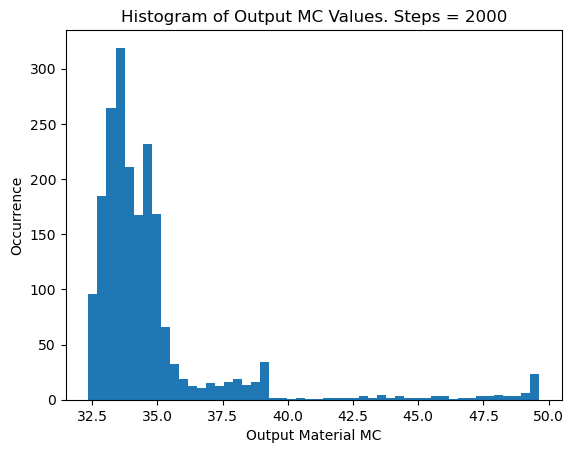

In [28]:
# evaluating trained RL
obs = biomass_dryer_env.reset()
total_rewards = []
all_obs = []

steps = 2000

for i in range(steps):
    action, _states = rnn_ppo_model.predict(obs)
    obs, rewards, terminated, info = biomass_dryer_env.step(action)
    all_obs.append(obs)
    
    total_rewards += [rewards]
    # print(f"episode_{i+1} total rewards: {total_rewards}")

print(f"Average total rewards: {np.median(total_rewards):.2f}")
print(f"Average output MC: {np.median([obs[0][0] for obs in all_obs]):.2f}")        

# Calculate the histogram data using numpy.histogram()
hist, bin_edges = np.histogram([obs[0][0] for obs in all_obs], bins=50)

# Plot the histogram using Matplotlib
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
plt.xlabel('Output Material MC')
plt.ylabel('Occurrence')
plt.title(f'Histogram of Output MC Values. Steps = {steps}')
plt.show()